# PyTorch, EMNIST

# Подготовка модели распознавания рукописных букв и цифр

# Библиотеки

In [1]:
import os
import torch
import torchvision
from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import cv2
from PIL import Image
from torchinfo import summary

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

# Получение, трансформация, нормализация и контроль данных

In [3]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

In [4]:
# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('data/', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [5]:
# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('data/', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [6]:
# получение маппинга
with open('emnist-balanced-mapping.txt', 'r') as f:
    mapping = f.readlines()

#mapping

In [7]:
# Создаем словарь соответствий
label_dict = {}
for entry in mapping:
    label, ascii_code = map(int, entry.split())
    label_dict[label] = chr(ascii_code)

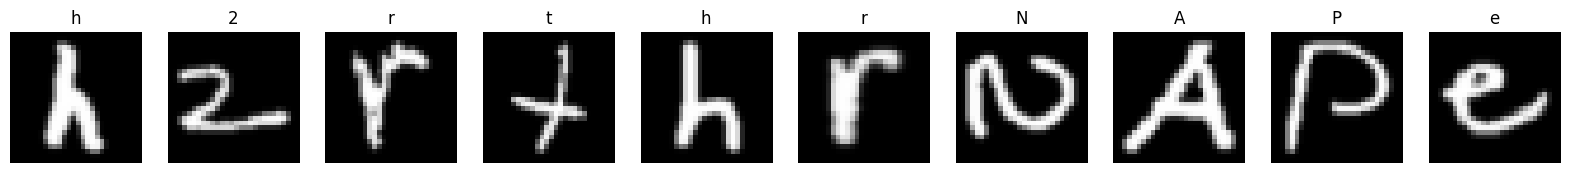

In [8]:
# Проверяем корректность изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()


In [9]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Моделирование

Сверточная нейронная сеть (CNN)

In [11]:

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 47)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x




In [11]:
# Инициализация модели
model_cnn = CNNModel()

## Первый этап обучения

30 эпох, lr=0.001

In [12]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [13]:
n_epochs = 30

for epoch in range(n_epochs):
    model_cnn.train()  # Устанавливаем режим обучения
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()  # Обнуляем градиенты
        output = model_cnn(data)  # Прямой проход через модель
        loss = loss_function(output, target)  # Вычисление потерь
        loss.backward()  # Обратный проход (вычисление градиентов)
        optimizer.step()  # Обновление параметров

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/30, Loss: 0.8365
Validation Accuracy: 0.8447
Epoch 2/30, Loss: 0.5169
Validation Accuracy: 0.8678
Epoch 3/30, Loss: 0.4602
Validation Accuracy: 0.8746
Epoch 4/30, Loss: 0.4214
Validation Accuracy: 0.8753
Epoch 5/30, Loss: 0.3925
Validation Accuracy: 0.8793
Epoch 6/30, Loss: 0.3688
Validation Accuracy: 0.8809
Epoch 7/30, Loss: 0.3489
Validation Accuracy: 0.8878
Epoch 8/30, Loss: 0.3295
Validation Accuracy: 0.8853
Epoch 9/30, Loss: 0.3162
Validation Accuracy: 0.8869
Epoch 10/30, Loss: 0.2986
Validation Accuracy: 0.8894
Epoch 11/30, Loss: 0.2858
Validation Accuracy: 0.8906
Epoch 12/30, Loss: 0.2772
Validation Accuracy: 0.8904
Epoch 13/30, Loss: 0.2665
Validation Accuracy: 0.8893
Epoch 14/30, Loss: 0.2553
Validation Accuracy: 0.8895
Epoch 15/30, Loss: 0.2461
Validation Accuracy: 0.8929
Epoch 16/30, Loss: 0.2375
Validation Accuracy: 0.8911
Epoch 17/30, Loss: 0.2302
Validation Accuracy: 0.8916
Epoch 18/30, Loss: 0.2220
Validation Accuracy: 0.8908
Epoch 19/30, Loss: 0.2151
Validation 

In [14]:
n_epoch = 30

In [15]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'data/model_a.ckpt')

# Сохранение обученной модели
checkpoint = {
    'model_state_dict': model_cnn.state_dict(),  # Состояние модели
    'optimizer_state_dict': optimizer.state_dict(),  # Состояние оптимизатора
    'epoch': n_epoch  # Текущий номер эпохи (если нужно возобновить обучение)
}

# Сохранение контрольной точки в файл .ckpt
torch.save(checkpoint, 'data/model_a_checkpoint.ckpt')

## Второй этап обучения

20 эпох, lr=0.0005

In [16]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print(n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 20  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a.ckpt'))  # Замените на путь к вашей модели
#model.eval()  # Установка модели в режим оценки

30


/tmp/ipykernel_5144/1660173255.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint.ckpt')
/tmp/ipykernel_5144/1660173255.py:

<All keys matched successfully>

In [17]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0005)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [18]:
for epoch in range(start_epoch, start_epoch + n_epochs_to_continue):
    model_cnn.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model_cnn(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch}/{start_epoch + n_epochs_to_continue}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 31/51, Loss: 0.1346
Validation Accuracy: 0.8933
Epoch 32/51, Loss: 0.1223
Validation Accuracy: 0.8909
Epoch 33/51, Loss: 0.1177
Validation Accuracy: 0.8903
Epoch 34/51, Loss: 0.1141
Validation Accuracy: 0.8894
Epoch 35/51, Loss: 0.1103
Validation Accuracy: 0.8906
Epoch 36/51, Loss: 0.1071
Validation Accuracy: 0.8888
Epoch 37/51, Loss: 0.1058
Validation Accuracy: 0.8880
Epoch 38/51, Loss: 0.1019
Validation Accuracy: 0.8874
Epoch 39/51, Loss: 0.0994
Validation Accuracy: 0.8856
Epoch 40/51, Loss: 0.0969
Validation Accuracy: 0.8888
Epoch 41/51, Loss: 0.0963
Validation Accuracy: 0.8880
Epoch 42/51, Loss: 0.0920
Validation Accuracy: 0.8869
Epoch 43/51, Loss: 0.0910
Validation Accuracy: 0.8877
Epoch 44/51, Loss: 0.0891
Validation Accuracy: 0.8882
Epoch 45/51, Loss: 0.0866
Validation Accuracy: 0.8886
Epoch 46/51, Loss: 0.0850
Validation Accuracy: 0.8877
Epoch 47/51, Loss: 0.0834
Validation Accuracy: 0.8884
Epoch 48/51, Loss: 0.0820
Validation Accuracy: 0.8870
Epoch 49/51, Loss: 0.0801
Va

In [19]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'data/model_a_1.ckpt')

# Сохранение обученной модели
new_checkpoint = {
    'model_state_dict': model_cnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': start_epoch + n_epochs_to_continue - 1,
}
# Сохранение контрольной точки в файл .ckpt
torch.save(new_checkpoint, 'data/model_a_checkpoint_1.ckpt')

## Третий этап обучения

20 эпох, lr=0.0001

In [20]:
# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint_1.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print(n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 20  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a_1.ckpt'))  # Замените на путь к вашей модели
#model.eval()  # Установка модели в режим оценки

50


/tmp/ipykernel_5144/3857648320.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint_1.ckpt')
/tmp/ipykernel_5144/3857648320.p

<All keys matched successfully>

In [21]:
# Оптимизатор и функция потерь
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0001)  # Используем Adam с малой скоростью обучения
loss_function = nn.CrossEntropyLoss()  # Функция потерь для многоклассовой классификации

In [22]:
for epoch in range(start_epoch, start_epoch + n_epochs_to_continue):
    model_cnn.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model_cnn(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch}/{start_epoch + n_epochs_to_continue}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model_cnn.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model_cnn(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 51/71, Loss: 0.0658
Validation Accuracy: 0.8882
Epoch 52/71, Loss: 0.0595
Validation Accuracy: 0.8901
Epoch 53/71, Loss: 0.0571
Validation Accuracy: 0.8907
Epoch 54/71, Loss: 0.0553
Validation Accuracy: 0.8890
Epoch 55/71, Loss: 0.0540
Validation Accuracy: 0.8882
Epoch 56/71, Loss: 0.0529
Validation Accuracy: 0.8882
Epoch 57/71, Loss: 0.0505
Validation Accuracy: 0.8887
Epoch 58/71, Loss: 0.0505
Validation Accuracy: 0.8882
Epoch 59/71, Loss: 0.0491
Validation Accuracy: 0.8887
Epoch 60/71, Loss: 0.0489
Validation Accuracy: 0.8887
Epoch 61/71, Loss: 0.0482
Validation Accuracy: 0.8886
Epoch 62/71, Loss: 0.0475
Validation Accuracy: 0.8896
Epoch 63/71, Loss: 0.0475
Validation Accuracy: 0.8889
Epoch 64/71, Loss: 0.0464
Validation Accuracy: 0.8876
Epoch 65/71, Loss: 0.0454
Validation Accuracy: 0.8888
Epoch 66/71, Loss: 0.0451
Validation Accuracy: 0.8880
Epoch 67/71, Loss: 0.0447
Validation Accuracy: 0.8893
Epoch 68/71, Loss: 0.0437
Validation Accuracy: 0.8878
Epoch 69/71, Loss: 0.0433
Va

In [23]:
# Сохранение модели в формате .ckpt
torch.save(model_cnn.state_dict(), 'data/model_a_2.ckpt')

# Сохранение обученной модели
new_checkpoint = {
    'model_state_dict': model_cnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': start_epoch + n_epochs_to_continue - 1,
}
# Сохранение контрольной точки в файл .ckpt
torch.save(new_checkpoint, 'data/model_a_checkpoint_2.ckpt')

# Оценка модели

In [13]:
model_cnn = CNNModel() 
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0001) 

# Загрузка контрольной точки
checkpoint = torch.load('data/model_a_checkpoint_2.ckpt')

# Восстановление состояния модели и оптимизатора
model_cnn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Если нужно, можно восстановить номер эпохи
n_epoch = checkpoint['epoch']
print('epoches', n_epoch)

# Восстановление номера эпохи
start_epoch = checkpoint['epoch'] + 1  # Начинаем с следующей эпохи

# Параметры для продолжения обучения
n_epochs_to_continue = 5  # Количество дополнительных эпох

# Загрузка предварительно обученной модели
model_cnn = CNNModel()  # Предполагается, что модель определена
model_cnn.load_state_dict(torch.load('data/model_a_2.ckpt'))  # Замените на путь к вашей модели
model_cnn.eval()  # Установка модели в режим оценки

epoches 70


/tmp/ipykernel_5766/634312125.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('data/model_a_checkpoint_2.ckpt')
/tmp/ipykernel_5766/634312125.py:

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=47, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [14]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model_cnn(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.67
1
Accuracy of class 1: 0.66
2
Accuracy of class 2: 0.90
3
Accuracy of class 3: 0.98
4
Accuracy of class 4: 0.93
5
Accuracy of class 5: 0.91
6
Accuracy of class 6: 0.93
7
Accuracy of class 7: 0.98
8
Accuracy of class 8: 0.96
9
Accuracy of class 9: 0.73
A
Accuracy of class 10: 0.98
B
Accuracy of class 11: 0.97
C
Accuracy of class 12: 0.95
D
Accuracy of class 13: 0.92
E
Accuracy of class 14: 0.98
F
Accuracy of class 15: 0.70
G
Accuracy of class 16: 0.97
H
Accuracy of class 17: 0.97
I
Accuracy of class 18: 0.65
J
Accuracy of class 19: 0.95
K
Accuracy of class 20: 0.98
L
Accuracy of class 21: 0.49
M
Accuracy of class 22: 0.97
N
Accuracy of class 23: 0.98
O
Accuracy of class 24: 0.65
P
Accuracy of class 25: 0.96
Q
Accuracy of class 26: 0.94
R
Accuracy of class 27: 0.98
S
Accuracy of class 28: 0.94
T
Accuracy of class 29: 0.93
U
Accuracy of class 30: 0.93
V
Accuracy of class 31: 0.94
W
Accuracy of class 32: 0.99
X
Accuracy of class 33: 0.97
Y
Accuracy of class 34: 

In [15]:
# Вывод результатов по каждому классу с accuracy < 0.87
print("Classes with accuracy < 0.87:")
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        if accuracy < 0.87:  # Проверяем условие на точность
            print(label_dict[i])  # Выводим метку класса
            print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

Classes with accuracy < 0.87:
0
Accuracy of class 0: 0.67
1
Accuracy of class 1: 0.66
9
Accuracy of class 9: 0.73
F
Accuracy of class 15: 0.70
I
Accuracy of class 18: 0.65
L
Accuracy of class 21: 0.49
O
Accuracy of class 24: 0.65
f
Accuracy of class 40: 0.59
g
Accuracy of class 41: 0.69
q
Accuracy of class 44: 0.62


In [16]:
# Вывод информации о модели
summary(model_cnn, input_size=(1, 1, 28, 28))  # Указываем размер входного тензора [batch_size, channels, height, width]

[W108 11:10:29.435520263 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 47]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─BatchNorm2d: 1-2                       [1, 32, 28, 28]           64
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Conv2d: 1-7                            [1, 128, 7, 7]            73,856
├─BatchNorm2d: 1-8                       [1, 128, 7, 7]            256
├─MaxPool2d: 1-9                         [1, 128, 3, 3]            --
├─Linear: 1-10                           [1, 256]                  295,168
├─Dropout: 1-11                          [1, 256]                  --
├─Linear: 1-12                           [1, 47]                   12

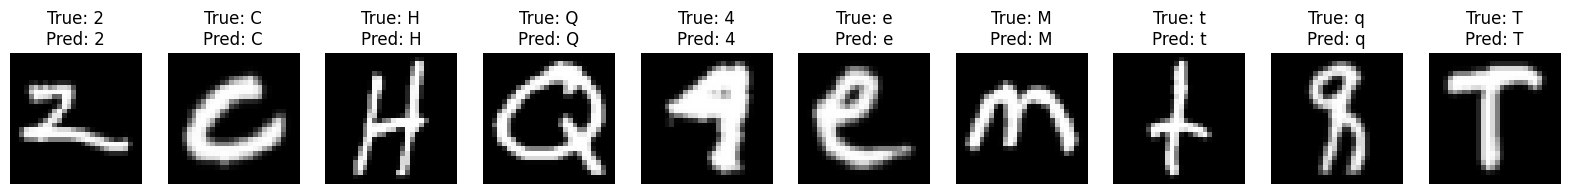

In [17]:
def predict(image):
    # Применяем преобразования к изображению, если они требуются
    # image = transform(input_image)  # Примените необходимые преобразования
    # Убедитесь, что изображение имеет форму (1, 1, H, W) для модели
    if image.dim() == 2:  # Если изображение 2D (H, W)
        image = image.unsqueeze(0)  # Добавляем размер канала
    image = image.unsqueeze(0)  # Добавляем размер батча

    #print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model_cnn(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        #print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # Получаем предсказанную метку
        #print('predicted symbol:', pred)

    return pred

# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.squeeze(0).numpy()  # Убираем размер канала и преобразуем в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()  # Устанавливаем модель в режим оценки
    criterion = nn.CrossEntropyLoss()  # Функция потерь
    total_loss = 0.0
    correct = 0
    class_correct = [0] * 47  # Для каждого из 47 классов
    class_total = [0] * 47

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)  # Получаем предсказания от модели
            
            # Вычисление потерь
            loss = criterion(output, target)
            total_loss += loss.item()

            # Получение предсказаний
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

            # Подсчет правильных предсказаний для каждого класса
            for i in range(len(target)):
                label = target[i].item()  # Получаем метку класса
                class_correct[label] += (pred[i] == label).item()  # Увеличиваем счетчик для правильного предсказания
                class_total[label] += 1  # Увеличиваем общее количество примеров для данного класса

    # Вычисляем общую точность и среднюю потерю
    accuracy = correct / len(test_loader.dataset)
    average_loss = total_loss / len(test_loader)

    print(f'Overall Accuracy: {accuracy:.4f}')
    print(f'Average Loss: {average_loss:.4f}')

    # Вывод результатов по каждому классу
    for i in range(47):
        if class_total[i] > 0:  # Избегаем деления на ноль
            class_accuracy = class_correct[i] / class_total[i]
            #print(f'Accuracy of class {i}: {class_accuracy:.2f}')
        else:
            print(f'Class {i} has no samples in the test set.')



Overall Accuracy: 0.8869
Average Loss: 0.7548


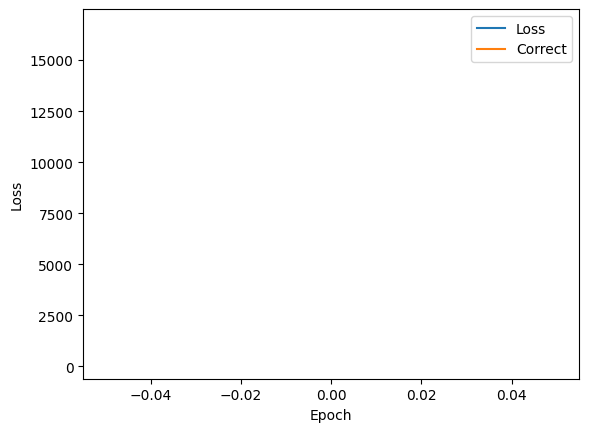

In [27]:
evaluate_model(model_cnn, val_loader)